
## This notebook shows how to use Grizli to

Retrieve and reduce raw CLEAR G102/F105W and 3D-HST G141/F140W observations for a specific CLEAR pointing (GS1).
        
** more comments inbound

These series of notebooks draw heavily from Gabe Brammer's existing grizli notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with specific focus for the CLEAR survey.

In [1]:
import grizli
from hsaquery import query, overlaps
import os
import numpy as np
from grizli.pipeline import auto_script
import glob
from glob import glob
import astropy
from grizli.prep import process_direct_grism_visit
from astropy.io import fits


## The paths defined below need to be changed to your own directories.
### the PATH_TO_CATS directory should include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
### these are all available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/
### the HOME_PATH directory is where the raw data, reduced data, and grizli outputs will be stored


In [2]:
field           = 'GS1'
ref_filter      = 'F105W'

HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'

if not os.path.isdir(HOME_PATH): os.system('mkdir %s'%HOME_PATH)
if not os.path.isdir(HOME_PATH + '/query_results'): os.system('mkdir %s/query_results'%HOME_PATH)

os.chdir(HOME_PATH)


## Run an initial query for all raw G102 data in the ESA archive with a target name that includes the phrase 'GS1' and a proposal ID of 14227 (i.e., GS1 pointing of CLEAR). 

In [8]:
if True:
    # The parent query targets only the G102 observations in the CLEAR pointing 'GS1'
    extra = query.DEFAULT_EXTRA.copy()
    extra += ["TARGET.TARGET_NAME LIKE '%s'"%field]

    # proposid 14227 = CLEAR
    parent = query.run_query(proposid = [14227], instruments=['WFC3-IR', 'ACS-WFC'], 
                         extensions=['FLT'], filters=['G102'], extra = extra)



## Then, find all overlapping G102 and G141 observations.

Parse 1
Parse 2
Parse 3
Parse 4
Parse 5
Parse 6
Parse 7
Parse 8
Parse 9
Parse 10
Parse 11
Parse 12
Parse 13
Parse 14
Parse 15
Parse 16
Parse 17
Parse 18
Parse 19
Parse 20
Parse 21
Parse 22
Parse 23
Iter #1, N_Patch = 1


 0 j033259-274124 53.25006791667 -27.68959166667
 TARGET_NAME 
-------------
GOODS-SOUTH-1
          GS1 

filter j033259-274124          WFC3-IR G102   24   27672.9
filter j033259-274124          WFC3-IR G141    8   37694.0


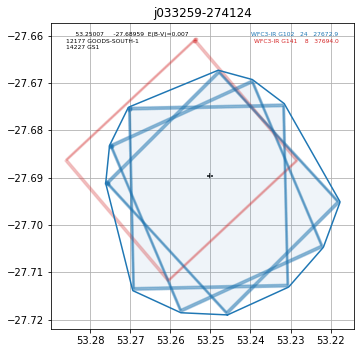

In [9]:
if True:
    # Finding all overlapping G102 and G141 observations in the archive
    tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, filters=['G102', 'G141'], 
                                  instruments=['WFC3-IR','WFC3-UVIS','ACS-WFC'], extra=[], 
                                  close=False)

    footprint_fits_file = glob('*footprint.fits')[0]
    jtargname = footprint_fits_file.strip('_footprint.fits')

    fp_fits = fits.open(footprint_fits_file)

    overlapping_target_names = set(fp_fits[1].data['target'])
    s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
    
    # Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
    os.system('cp %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, 'all_G102_G141'))
    os.system('cp %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
    os.system('cp %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
    os.system('cp %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))


## We now have a list of the target names for the G102 and G141 observations in the ESA archive that overlap with the GS1 pointing of CLEAR. 

### For each target name, search the archive and retrieve all associated grism G102/G141 and direct imaging F098M/F105W/F125W/F140W observations.

**For GS1, the retrieval step takes about 30 minutes to run and requires 1.9 GB of space.


Parse 1
Parse 2
Parse 3
Parse 4
Parse 5
Parse 6
Parse 7
Parse 8
Parse 9
Parse 10
Parse 11
Parse 12
Parse 13
Parse 14
Parse 15
Parse 16
Parse 17
Parse 18
Parse 19
Parse 20
Parse 21
Parse 22
Parse 23
Iter #1, N_Patch = 1


 0 j033259-274124 53.25006791667 -27.68959166667
TARGET_NAME
-----------
        GS1 

filter j033259-274124         WFC3-IR F105W   12    3186.4
filter j033259-274124          WFC3-IR G102   24   27672.9


KeyError: 'instrument_name'

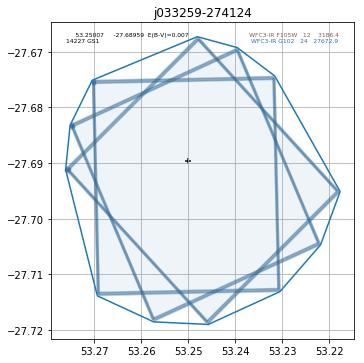

In [11]:
if True:
    for t, targ_name in enumerate(overlapping_target_names):

        extra = query.DEFAULT_EXTRA.copy()
        extra += ["TARGET.TARGET_NAME LIKE '%s'"%field]
        # search the ESA archive for overlapping grism and direct imaging observations with that target name
        tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, filters=['G102', 'G141', 'F098M', 'F105W', 'F125W', 'F140W'], 
                                      instruments=['WFC3-IR','WFC3-UVIS','ACS-WFC'], extra=extra, close=False)
        s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
        
        #retrieve the raw data products
        auto_script.fetch_files(field_root=jtargname, HOME_PATH=HOME_PATH, remove_bad=True, 
                                reprocess_parallel=True, s3_sync=(s3_status == 0))
        
        # Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
        os.system('mv %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
        os.system('mv %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
        os.system('mv %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
        os.system('mv %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))

        os.chdir(HOME_PATH)

In [6]:
# PATH_TO_RAW and PATH_TO_PREP are created in the previous steps
PATH_TO_RAW     = glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob(HOME_PATH + '/*/PREP')[0]


class Pointing():
    """ Generalization of GN1, GS1, ERSPRIME, etc

    To change field-dependent catalog, seg map, ref image, and padding
    only need to change them here.

    """
    def __init__(self, field, ref_filter):
        if 'N' in field.upper():
            self.pad = 500
            self.radec_catalog = PATH_TO_CATS + '/old_radeccats/goodsN_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_N_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
            
            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodsn_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodsn', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodsn', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodsn']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodsn', 'v4.1')

        elif 'S' in field.upper():
            self.pad = 200 # grizli default
            self.radec_catalog =  PATH_TO_CATS + '/old_radeccats/goodsS_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_S_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sci.fits'


            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodss_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodss', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodss', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodss']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodss', 'v4.1')




def readEazyBinary(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY='./OUTPUT', CACHE_FILE='Same'):

    """
    Author: Gabe Brammer
    This function has been clipped from eazyPy.py in thethreedhst git respository
    https://github.com/gbrammer/threedhst/tree/master/threedhst

    tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE='photz', \
                                                OUTPUT_DIRECTORY='./OUTPUT', \
                                                CACHE_FILE = 'Same')

    Read Eazy BINARY_OUTPUTS files into structure data.
    
    If the BINARY_OUTPUTS files are not in './OUTPUT', provide either a relative or absolute path
    in the OUTPUT_DIRECTORY keyword.
    
    By default assumes that CACHE_FILE is MAIN_OUTPUT_FILE+'.tempfilt'.
    Specify the full filename if otherwise. 
    """
    
    #root='COSMOS/OUTPUT/cat3.4_default_lines_zp33sspNoU'
    
    root = OUTPUT_DIRECTORY+'/'+MAIN_OUTPUT_FILE
    
    ###### .tempfilt
    if CACHE_FILE == 'Same':
        CACHE_FILE = root+'.tempfilt'
    
    if os.path.exists(CACHE_FILE) is False:
        print(('File, %s, not found.' %(CACHE_FILE)))
        return -1,-1,-1,-1
    
    f = open(CACHE_FILE,'rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    tempfilt = np.fromfile(file=f,dtype=np.double,count=NFILT*NTEMP*NZ).reshape((NZ,NTEMP,NFILT)).transpose()
    lc = np.fromfile(file=f,dtype=np.double,count=NFILT)
    zgrid = np.fromfile(file=f,dtype=np.double,count=NZ)
    fnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    efnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    
    f.close()
    
    tempfilt  = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
                 'tempfilt':tempfilt,'lc':lc,'zgrid':zgrid,'fnu':fnu,'efnu':efnu}
    
    ###### .coeff
    f = open(root+'.coeff','rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    coeffs = np.fromfile(file=f,dtype=np.double,count=NTEMP*NOBJ).reshape((NOBJ,NTEMP)).transpose()
    izbest = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
    tnorm = np.fromfile(file=f,dtype=np.double,count=NTEMP)
    
    f.close()
    
    coeffs = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
              'coeffs':coeffs,'izbest':izbest,'tnorm':tnorm}
              
    ###### .temp_sed
    f = open(root+'.temp_sed','rb')
    s = np.fromfile(file=f,dtype=np.int32, count=3)
    NTEMP=s[0]
    NTEMPL=s[1]
    NZ=s[2]
    templam = np.fromfile(file=f,dtype=np.double,count=NTEMPL)
    temp_seds = np.fromfile(file=f,dtype=np.double,count=NTEMPL*NTEMP).reshape((NTEMP,NTEMPL)).transpose()
    da = np.fromfile(file=f,dtype=np.double,count=NZ)
    db = np.fromfile(file=f,dtype=np.double,count=NZ)
    
    f.close()
    
    temp_sed = {'NTEMP':NTEMP,'NTEMPL':NTEMPL,'NZ':NZ,\
              'templam':templam,'temp_seds':temp_seds,'da':da,'db':db}
              
    ###### .pz
    if os.path.exists(root+'.pz'):
        f = open(root+'.pz','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=2)
        NZ=s[0]
        NOBJ=s[1]
        chi2fit = np.fromfile(file=f,dtype=np.double,count=NZ*NOBJ).reshape((NOBJ,NZ)).transpose()

        ### This will break if APPLY_PRIOR No
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        
        if len(s) > 0:
            NK = s[0]
            kbins = np.fromfile(file=f,dtype=np.double,count=NK)
            priorzk = np.fromfile(file=f, dtype=np.double, count=NZ*NK).reshape((NK,NZ)).transpose()
            kidx = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
            pz = {'NZ':NZ,'NOBJ':NOBJ,'NK':NK, 'chi2fit':chi2fit, 'kbins':kbins, 'priorzk':priorzk,'kidx':kidx}
        else:
            pz = None
        
        f.close()
        
    else:
        pz = None
    
    if False:
        f = open(root+'.zbin','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        NOBJ=s[0]
        z_a = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_p = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m1 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m2 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_peak = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        f.close()
        
    ###### Done.    
    return tempfilt, coeffs, temp_sed, pz



In [7]:
os.chdir(PATH_TO_PREP)
files = glob('%s/*flt.fits'%PATH_TO_RAW)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)


goodss-01-bhj-01-177.0-F140W 4
goodss-01-bhj-01-177.0-G141 4
GS1-cxt-09-227.0-F105W 2
GS1-cxt-10-227.0-F105W 2
GS1-cxt-07-249.0-F105W 2
GS1-cxt-08-249.0-F105W 2
GS1-cxt-11-269.0-F105W 2
GS1-cxt-12-269.0-F105W 2
GS1-cxt-09-227.0-G102 4
GS1-cxt-10-227.0-G102 4
GS1-cxt-07-249.0-G102 4
GS1-cxt-08-249.0-G102 4
GS1-cxt-11-269.0-G102 4
GS1-cxt-12-269.0-G102 4


In [8]:
if True:
    product_names = np.array([visit['product'] for visit in visits])
    filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
    basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])




    for ref_grism, ref_filter in [('G102', 'F105W'), ('G141', 'F140W')]:
        print(ref_grism, ref_filter)

        for v, visit in enumerate(visits):
            product = product_names[v]
            basename = basenames[v]
            filt1 = filter_names[v]
            field_in_contest = basename.split('-')[0]
            if (ref_filter.lower() == filt1.lower()):
                #Found a direct image, now search for grism counterpart
                grism_index= np.where((basenames == basename) & (filter_names == ref_grism.lower()))[0][0]
                p = Pointing(field = field, ref_filter = ref_filter)
                radec_catalog = p.radec_catalog
                print (field_in_contest, visits[grism_index])
                status = process_direct_grism_visit(direct = visit,
                                                    grism = visits[grism_index],
                                                    radec = radec_catalog, 
                                                    align_mag_limits = [14, 23])



G102 F105W
File, /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst.v4.1.tempfilt, not found.
gs1 OrderedDict([('product', 'gs1-cxt-09-227.0-g102'), ('files', ['icxt09f0q_flt.fits', 'icxt09f2q_flt.fits', 'icxt09f5q_flt.fits', 'icxt09f7q_flt.fits'])])
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
../RAW/icxt09ezq_flt.fits -> icxt09ezq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt09f4q_flt.fits -> icxt09f4q_flt.fits  

           Subtract Sky          0.3976 sec.
       Separate Drizzle          1.0339 sec.
          Create Median          0.5082 sec.
                   Blot          1.0345 sec.
                Driz_CR          1.0564 sec.
          Final Drizzle          2.4789 sec.
   ====================          ====================
                  Total          7.2902 sec.
Trailer file written to:  astrodrizzle.log
Image AB zeropoint: 26.269
SEP: err_scale=0.617
   SEP: Extract...


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer share

gs1-cxt-09-227.0-f105w.cat.fits: 238 objects
gs1-cxt-09-227.0-f105w (guess)   :   0.00   0.00   0.000   1.000


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=28, Nout=29, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (0) 25:   0.73  -2.87   0.039   1.000
  tristars.match: Nin=28, Nout=30, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (1) 25:  -0.33   0.37   0.000   1.000
  tristars.match: Nin=28, Nout=29, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (2) 25:  -0.00  -0.00   0.000   1.000
  tristars.match: Nin=28, Nout=29, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (3) 25:   0.00   0.00  -0.000   1.000
  tristars.match: Nin=28, Nout=29, match=29
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-09-227.0-f105w (4) 25:  -0.00  -0.00  -0.000   1.000
Initialize gs1-cxt-09-227.0-f105w_wcs.log

....Updating header for icxt09ezq_flt.fits...


Processing icxt09ezq_flt.fits['SCI',1]

Updating header for icxt09ezq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.878154283907886e-07 -3.3601493755184626e-05
CD_21  


....Updating header for icxt09f4q_flt.fits...


Processing icxt09f4q_flt.fits['SCI',1]

Updating header for icxt09f4q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.876849646717781e-07 -3.360147287860845e-05
CD_21  CD_22: -3.7613253808065785e-05 6.823641938156567e-07
CRVAL    : 53.25054820073082 -27.693962138882625
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543772092605463
ORIENTAT : -88.83662197117218
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:46:09.413 (11/10/2018)

==== Processing Step  Initialization  started at  21:46:09.416 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25000671512  -27.69418953945693  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -9.719237841015114e-07  -3.5611740280170384e-05  
CD2_1 CD2_2  : -3.5611740280170384e-05  9.719237841015114e-07  
NAXIS : 1091  969
********************************************************************

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1170: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

gs1-cxt-09-227.0-f105w.cat.fits: 272 objects
# id     ra           dec          mag     nDQ     nSat
    17    53.268616   -27.675547   14.33 [0, 0] [0, 16]
    77    53.258262   -27.690571   16.10 [0, 0] [9, 6]
    76    53.258192   -27.690377   16.11 [0, 0] [4, 4]
   189    53.244534   -27.710167   17.88 [0, 0] [0, 0]
    98    53.256053   -27.683790   19.17 [0, 0] [1, 0]
    36    53.265629   -27.683495   19.32 [0, 0] [0, 0]
   154    53.248824   -27.677559   19.44 [0, 0] [0, 0]
    24    53.265644   -27.688120   19.66 [0, 0] [0, 0]
   146    53.249229   -27.685525   19.88 [0, 0] [0, 0]
    61    53.259660   -27.694149   19.91 [0, 0] [0, 0]
    60    53.260211   -27.694355   20.58 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:46:18.298 (11/10/2018)

==== Processing Step  Initialization  started at  21:46:18.301 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.2500


....Updating header for icxt09f2q_flt.fits...


Processing icxt09f2q_flt.fits['SCI',1]

Updating header for icxt09f2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.846922423933399e-07 -3.359469516261598e-05
CD_21  CD_22: -3.760936985174293e-05 6.777970011256897e-07
CRVAL    : 53.250304155613996 -27.69382668601383
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542305984200367
ORIENTAT : -88.84417348461403
WCSNAME  :  USER



....Updating header for icxt09f5q_flt.fits...


Processing icxt09f5q_flt.fits['SCI',1]

Updating header for icxt09f5q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.845788120474787e-07 -3.3595323257714114e-05
CD_21  CD_22: -3.761007348619434e-05 6.776935527395699e-07
CRVAL    : 53.250548201959305 -27.69396213882868
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354255824087627
ORIENTAT : -88.8443714442122
WCSNAME  :  USER



....Updating header for icxt09f7q_flt.fits...


Processing icxt09f7q_flt.fits['SCI',1]

Updating header for icxt09f7q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.846304854955638e-07 -3.3594623716226416e-05
CD_21  CD_22: -3.760929009819337e-05 6.777420366463993e-07
CRVAL    : 53.25040622129888 -27.694336857818143
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354227676121837
ORIENTAT : -88.84426473118307
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:46:23.530 (11/10/2018)

==== Processing Step  Initialization  started at  21:46:23.533 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.250006509899904  -27.694190729308765  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -9.719237841015114e-07  -3.5611740280170384e-05  
CD2_1 CD2_2  : -3.5611740280170384e-05  9.719237841015114e-07  
NAXIS : 1098  969
****************************************************************



AstroDrizzle Version 2.2.4 is finished processing at 21:46:35.183 (11/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.4706 sec.
            Static Mask          0.1235 sec.
           Subtract Sky          0.7780 sec.
       Separate Drizzle          1.0469 sec.
          Create Median          0.8909 sec.
                   Blot          2.2720 sec.
                Driz_CR          1.1399 sec.
          Final Drizzle          3.8899 sec.
   ====================          ====================
                  Total          11.6117 sec.
Trailer file written to:  astrodrizzle.log
gs1-cxt-09-227.0-g102: EXTVER=1 / ['zodi_G102_clean.fits'] / ['excess_G102_clean.fits']


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3222: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3260: RuntimeWarning: invalid value encountered in sqrt
  resid = (data-model)*np.sqrt(wht)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3275: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-09-227.0-g102 > Iter: 1, masked: 57%, [0.47569662 0.14839715 0.         0.11978519 0.00438309]
   gs1-cxt-09-227.0-g102 > Iter: 2, masked: 55%, [0.4661023  0.15284622 0.00491986 0.12439185 0.00926901]
   gs1-cxt-09-227.0-g102 > Iter: 3, masked: 55%, [0.46498376 0.15342957 0.00551555 0.12497285 0.00985675]
   gs1-cxt-09-227.0-g102 > Iter: 4, masked: 55%, [0.46476135 0.15359662 0.00568257 0.12515104 0.01000311]


/anaconda2/envs/grizli/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:46:57.063 (11/10/2018)

==== Processing Step  Initialization  started at  21:46:57.068 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.250006509899904  -27.694190729308765  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -9.719237841015114e-07  -3.5611740280170384e-05  
CD2_1 CD2_2  : -3.5611740280170384e-05  9.719237841015114e-07  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:46:58.534 (11/10/2018)

==== Processing Step  Static Mask  started at  21:46:58.53 (11/10/2018)
==== Processing Step  Static 

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt10dhq_flt.fits -> icxt10dhq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt10dbq_flt.fits -> icxt10dbq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt10deq_flt.fits -> icxt10deq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt10diq_flt.fits -> icxt10diq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

icxt10daq_flt.fits [ 0.000,  0.000]  [ 0.000,  0.000] N=50
icxt10dhq_flt.fits [ 0.059, -0.007]  [ 0.039,  0.032] N=42


gs1-cxt-10-227.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:47:14.805 (11/10/2018)

==== Processing Step  Initialization  started at  21:47:14.808 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25009201469871  -27.69419444658721  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -9.719237841230432e-07  -3.5611740280169794e-05  
CD2_1 CD2_2  : -3.5611740280169794e-05  9.719237841230432e-07  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:47:15.487 (11/10/2018)

==== Processing Step  Static Mask  started at  21:47:15.490 (11/1

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer share

gs1-cxt-10-227.0-f105w.cat.fits: 246 objects
gs1-cxt-10-227.0-f105w (guess)   :   0.00   0.00   0.000   1.000


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=28, Nout=30, match=29
  tristars.match: Nin=23, Nout=23, match=23
gs1-cxt-10-227.0-f105w (0) 23:   0.75  -2.78   0.042   1.000
  tristars.match: Nin=28, Nout=31, match=29
  tristars.match: Nin=23, Nout=23, match=23
gs1-cxt-10-227.0-f105w (1) 23:  -0.36   0.40   0.000   1.000


/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/transform/_geometric.py:142: RuntimeWarning: invalid value encountered in multiply
  T[:dim, :dim] *= scale


  tristars.match: Nin=28, Nout=31, match=29
  tristars.match: Nin=23, Nout=23, match=23
gs1-cxt-10-227.0-f105w (2) 23:   0.00   0.00   0.000   1.000
  tristars.match: Nin=28, Nout=31, match=29
  tristars.match: Nin=23, Nout=23, match=23
gs1-cxt-10-227.0-f105w (3) 23:  -0.00  -0.00  -0.000   1.000
  tristars.match: Nin=28, Nout=31, match=29
  tristars.match: Nin=23, Nout=23, match=23
gs1-cxt-10-227.0-f105w (4) 23:   0.00   0.00  -0.000   1.000
Initialize gs1-cxt-10-227.0-f105w_wcs.log

....Updating header for icxt10daq_flt.fits...




Processing icxt10daq_flt.fits['SCI',1]

Updating header for icxt10daq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.857900204212431e-07 -3.3603324037198634e-05
CD_21  CD_22: -3.7615332342086636e-05 6.806653779777551e-07
CRVAL    : 53.25016674650032 -27.694200980472992
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354363069374341
ORIENTAT : -88.83958143920017
WCSNAME  :  USER

....Updating header for icxt10dhq_flt.fits...




Processing icxt10dhq_flt.fits['SCI',1]

Updating header for icxt10dhq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.856612967419122e-07 -3.360337051917159e-05
CD_21  CD_22: -3.761538478599389e-05 6.805502237947059e-07
CRVAL    : 53.250553183694684 -27.693961267870183
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543648486797277
ORIENTAT : -88.83977930824857
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:47:24.022 (11/10/2018)

==== Processing Step  Initialization  started at  21:47:24.026 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25001391242222  -27.694188621979357  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -9.719237841021044e-07  -3.561174028017036e-05  
CD2_1 CD2_2  : -3.561174028017036e-05  9.719237841021044e-07  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up 

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1170: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

gs1-cxt-10-227.0-f105w.cat.fits: 284 objects
# id     ra           dec          mag     nDQ     nSat
    26    53.268617   -27.675543   14.30 [0, 0] [0, 17]
    82    53.258264   -27.690570   16.10 [0, 0] [9, 7]
    81    53.258195   -27.690372   16.11 [0, 0] [4, 4]
   203    53.244540   -27.710170   17.88 [0, 0] [0, 0]
    41    53.265633   -27.683499   18.69 [0, 0] [0, 0]
   104    53.256055   -27.683787   19.16 [0, 0] [1, 0]
   165    53.248826   -27.677558   19.47 [0, 0] [0, 0]
    30    53.265646   -27.688118   19.68 [0, 0] [0, 0]
   157    53.249231   -27.685524   19.88 [0, 0] [0, 0]
    67    53.259660   -27.694150   19.92 [0, 0] [0, 0]
    66    53.260210   -27.694355   20.59 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:47:32.992 (11/10/2018)

==== Processing Step  Initialization  started at  21:47:32.995 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.2500


....Updating header for icxt10deq_flt.fits...


Processing icxt10deq_flt.fits['SCI',1]

Updating header for icxt10deq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.826211721654262e-07 -3.3595909807784415e-05
CD_21  CD_22: -3.7610736683416594e-05 6.7594306962063e-07
CRVAL    : 53.25030902253532 -27.693827128122948
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.135419677517496
ORIENTAT : -88.84737574612566
WCSNAME  :  USER



....Updating header for icxt10diq_flt.fits...


Processing icxt10diq_flt.fits['SCI',1]

Updating header for icxt10diq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.825198616885895e-07 -3.359700236073376e-05
CD_21  CD_22: -3.7611960286871976e-05 6.758489043519877e-07
CRVAL    : 53.25055318227246 -27.693961266573687
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542407210439403
ORIENTAT : -88.84757374155996
WCSNAME  :  USER



....Updating header for icxt10dkq_flt.fits...


Processing icxt10dkq_flt.fits['SCI',1]

Updating header for icxt10dkq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -8.825618507919122e-07 -3.359593132149202e-05
CD_21  CD_22: -3.761076096710748e-05 6.758900005250296e-07
CRVAL    : 53.25041112654978 -27.694337325489155
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541975992698357
ORIENTAT : -88.84746695346354
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:47:38.193 (11/10/2018)

==== Processing Step  Initialization  started at  21:47:38.1 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25001354493696  -27.694191527006367  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -9.719237841021044e-07  -3.561174028017036e-05  
CD2_1 CD2_2  : -3.561174028017036e-05  9.719237841021044e-07  
NAXIS : 1098  969
*********************************************************************



AstroDrizzle Version 2.2.4 is finished processing at 21:47:48.977 (11/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.3333 sec.
            Static Mask          0.1047 sec.
           Subtract Sky          0.6407 sec.
       Separate Drizzle          1.0425 sec.
          Create Median          0.8617 sec.
                   Blot          2.1286 sec.
                Driz_CR          1.1089 sec.
          Final Drizzle          3.5242 sec.
   ====================          ====================
                  Total          10.7446 sec.
Trailer file written to:  astrodrizzle.log
gs1-cxt-10-227.0-g102: EXTVER=1 / ['zodi_G102_clean.fits'] / ['excess_G102_clean.fits']


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3222: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3260: RuntimeWarning: invalid value encountered in sqrt
  resid = (data-model)*np.sqrt(wht)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3275: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-10-227.0-g102 > Iter: 1, masked: 56%, [0.46179873 0.12254256 0.00233969 0.17643672 0.        ]
   gs1-cxt-10-227.0-g102 > Iter: 2, masked: 54%, [ 0.46168393  0.11758605 -0.00213146  0.17120762 -0.00456502]
   gs1-cxt-10-227.0-g102 > Iter: 3, masked: 54%, [ 0.46156704  0.11709381 -0.00251192  0.17070273 -0.00499371]
   gs1-cxt-10-227.0-g102 > Iter: 4, masked: 54%, [ 0.4616196   0.11697306 -0.00262685  0.17057794 -0.00510997]


/anaconda2/envs/grizli/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:48:13.62 (11/10/2018)

==== Processing Step  Initialization  started at  21:48:13.628 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25001354493696  -27.694191527006367  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -9.719237841021044e-07  -3.561174028017036e-05  
CD2_1 CD2_2  : -3.561174028017036e-05  9.719237841021044e-07  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:48:14.99 (11/10/2018)

==== Processing Step  Static Mask  started at  21:48:15.001 (11/10/2018)
==== Processing Step  Static Mask

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt07e1q_flt.fits -> icxt07e1q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt07dxq_flt.fits -> icxt07dxq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt07dzq_flt.fits -> icxt07dzq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt07e2q_flt.fits -> icxt07e2q_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

icxt07dwq_flt.fits [ 0.000,  0.000]  [ 0.000,  0.000] N=50
icxt07e1q_flt.fits [-0.034, -0.021]  [ 0.054,  0.051] N=46


gs1-cxt-07-249.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:48:31.418 (11/10/2018)

==== Processing Step  Initialization  started at  21:48:31.42 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.248104138476684  -27.693857195491614  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -1.4490434712585583e-05  -3.254486109149503e-05  
CD2_1 CD2_2  : -3.254486109149503e-05  1.4490434712585583e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:48:32.068 (11/10/2018)

==== Processing Step  Static Mask  started at  21:48:32.071 (11/

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer share

gs1-cxt-07-249.0-f105w.cat.fits: 246 objects
gs1-cxt-07-249.0-f105w (guess)   :   0.00   0.00   0.000   1.000


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=29, Nout=31, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (0) 25:   0.20  -3.29   0.032   1.000
  tristars.match: Nin=29, Nout=32, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (1) 25:  -0.27   0.30   0.000   1.000
  tristars.match: Nin=29, Nout=32, match=28


/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/transform/_geometric.py:142: RuntimeWarning: invalid value encountered in multiply
  T[:dim, :dim] *= scale


  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (2) 25:   0.00   0.00   0.000   1.000
  tristars.match: Nin=29, Nout=32, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (3) 25:   0.00   0.00  -0.000   1.000
  tristars.match: Nin=29, Nout=32, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-07-249.0-f105w (4) 25:   0.00  -0.00   0.000   1.000
Initialize gs1-cxt-07-249.0-f105w_wcs.log

....Updating header for icxt07dwq_flt.fits...




Processing icxt07dwq_flt.fits['SCI',1]

Updating header for icxt07dwq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5179521903455376e-05 -3.079320111808625e-05
CD_21  CD_22: -3.442241375841525e-05 1.3458237130629e-05
CRVAL    : 53.24814279509526 -27.693891748610582
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543630463838394
ORIENTAT : -66.39215960037079
WCSNAME  :  USER

....Updating header for icxt07e1q_flt.fits...




Processing icxt07e1q_flt.fits['SCI',1]

Updating header for icxt07e1q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.517942327635146e-05 -3.0793287976404856e-05
CD_21  CD_22: -3.442251131286952e-05 1.3458148739684708e-05
CRVAL    : 53.248601189362205 -27.69380390133215
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543648273033634
ORIENTAT : -66.39235699447879
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:48:40.629 (11/10/2018)

==== Processing Step  Initialization  started at  21:48:40.63 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24799929023558  -27.69382911631279  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -1.449043471260119e-05  -3.254486109148808e-05  
CD2_1 CD2_2  : -3.254486109148808e-05  1.449043471260119e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up t

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1170: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

gs1-cxt-07-249.0-f105w.cat.fits: 281 objects
# id     ra           dec          mag     nDQ     nSat
    92    53.258261   -27.690576   16.12 [0, 0] [7, 4]
    93    53.258183   -27.690382   16.13 [0, 0] [3, 2]
   123    53.244531   -27.710174   17.88 [0, 0] [0, 0]
   127    53.256051   -27.683793   19.13 [0, 0] [0, 0]
    65    53.265630   -27.683502   19.32 [0, 0] [0, 0]
   194    53.248821   -27.677563   19.39 [0, 0] [0, 0]
    42    53.265642   -27.688124   19.67 [0, 0] [0, 0]
    63    53.259657   -27.694153   19.89 [0, 0] [0, 0]
   166    53.249222   -27.685527   19.92 [0, 0] [0, 0]
    62    53.260207   -27.694358   20.58 [0, 0] [0, 0]
    72    53.263691   -27.683575   20.95 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:48:49.472 (11/10/2018)

==== Processing Step  Initialization  started at  21:48:49.476 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24799


....Updating header for icxt07dzq_flt.fits...


Processing icxt07dzq_flt.fits['SCI',1]

Updating header for icxt07dzq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5174847123846974e-05 -3.078826990834261e-05
CD_21  CD_22: -3.441950814003705e-05 1.3451049422884343e-05
CRVAL    : 53.24843547043429 -27.69359436190679
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354196753269727
ORIENTAT : -66.40002337523342
WCSNAME  :  USER



....Updating header for icxt07e2q_flt.fits...


Processing icxt07e2q_flt.fits['SCI',1]

Updating header for icxt07e2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.517527561545882e-05 -3.0789293954274096e-05
CD_21  CD_22: -3.4420653285699204e-05 1.3451428706508136e-05
CRVAL    : 53.24860119124831 -27.69380390076003
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354240698008174
ORIENTAT : -66.40012980732622
WCSNAME  :  USER



....Updating header for icxt07e4q_flt.fits...


Processing icxt07e4q_flt.fits['SCI',1]

Updating header for icxt07e4q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5174910941007983e-05 -3.078826732164169e-05
CD_21  CD_22: -3.4419505008242076e-05 1.3451106442415316e-05
CRVAL    : 53.24830983899495 -27.69410036133378
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541975767186726
ORIENTAT : -66.39993250554491
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:48:54.890 (11/10/2018)

==== Processing Step  Initialization  started at  21:48:54.894 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24799940462178  -27.693828409820473  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -1.449043471260119e-05  -3.254486109148808e-05  
CD2_1 CD2_2  : -3.254486109148808e-05  1.449043471260119e-05  
NAXIS : 1098  969
*****************************************************************



AstroDrizzle Version 2.2.4 is finished processing at 21:49:06.309 (11/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.3190 sec.
            Static Mask          0.1132 sec.
           Subtract Sky          0.5891 sec.
       Separate Drizzle          1.0453 sec.
          Create Median          0.8641 sec.
                   Blot          2.3411 sec.
                Driz_CR          1.1263 sec.
          Final Drizzle          3.9772 sec.
   ====================          ====================
                  Total          11.3751 sec.
Trailer file written to:  astrodrizzle.log
gs1-cxt-07-249.0-g102: EXTVER=1 / ['zodi_G102_clean.fits'] / ['excess_G102_clean.fits']


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3222: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3260: RuntimeWarning: invalid value encountered in sqrt
  resid = (data-model)*np.sqrt(wht)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3275: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-07-249.0-g102 > Iter: 1, masked: 56%, [0.46258843 0.14896601 0.00059393 0.21115267 0.        ]
   gs1-cxt-07-249.0-g102 > Iter: 2, masked: 54%, [ 0.46545     0.14086561 -0.00681006  0.20291519 -0.00735756]
   gs1-cxt-07-249.0-g102 > Iter: 3, masked: 53%, [ 0.4676637   0.13802277 -0.00952017  0.20010665 -0.01007911]
   gs1-cxt-07-249.0-g102 > Iter: 4, masked: 53%, [ 0.468318    0.1372953  -0.01023127  0.19938499 -0.01077309]


/anaconda2/envs/grizli/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:49:24.791 (11/10/2018)

==== Processing Step  Initialization  started at  21:49:24.7 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24799940462178  -27.693828409820473  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -1.449043471260119e-05  -3.254486109148808e-05  
CD2_1 CD2_2  : -3.254486109148808e-05  1.449043471260119e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:49:26.170 (11/10/2018)

==== Processing Step  Static Mask  started at  21:49:26.17 (11/10/2018)
==== Processing Step  Static Mask 

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt08ebq_flt.fits -> icxt08ebq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt08e7q_flt.fits -> icxt08e7q_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt08e9q_flt.fits -> icxt08e9q_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt08ecq_flt.fits -> icxt08ecq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

icxt08e6q_flt.fits [ 0.000, -0.000]  [ 0.000,  0.000] N=50
icxt08ebq_flt.fits [ 0.015, -0.013]  [ 0.053,  0.055] N=46


gs1-cxt-08-249.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:49:42.710 (11/10/2018)

==== Processing Step  Initialization  started at  21:49:42.713 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.248105238611174  -27.693855613074618  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -1.4490434712585583e-05  -3.254486109149503e-05  
CD2_1 CD2_2  : -3.254486109149503e-05  1.4490434712585583e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:49:43.39 (11/10/2018)

==== Processing Step  Static Mask  started at  21:49:43.401 (11/

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1170: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer share

gs1-cxt-08-249.0-f105w.cat.fits: 264 objects
gs1-cxt-08-249.0-f105w (guess)   :   0.00   0.00   0.000   1.000


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=30, Nout=33, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (0) 26:   0.31  -3.32   0.034   1.000
  tristars.match: Nin=30, Nout=34, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (1) 26:  -0.29   0.33   0.000   1.000
  tristars.match: Nin=30, Nout=33, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (2) 26:  -0.00   0.00  -0.000   1.000
  tristars.match: Nin=30, Nout=33, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (3) 26:   0.00  -0.00   0.000   1.000


/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)


  tristars.match: Nin=30, Nout=33, match=31
  tristars.match: Nin=26, Nout=26, match=26
gs1-cxt-08-249.0-f105w (4) 26:   0.00   0.00   0.000   1.000
Initialize gs1-cxt-08-249.0-f105w_wcs.log

....Updating header for icxt08e6q_flt.fits...




Processing icxt08e6q_flt.fits['SCI',1]

Updating header for icxt08e6q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5179560216594307e-05 -3.0796469612020076e-05
CD_21  CD_22: -3.4426072606124453e-05 1.3458260636416104e-05
CRVAL    : 53.248143920693295 -27.693888688341307
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354356907933417
ORIENTAT : -66.39435436115068
WCSNAME  :  USER

....Updating header for icxt08ebq_flt.fits...




Processing icxt08ebq_flt.fits['SCI',1]

Updating header for icxt08ebq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5179529657089104e-05 -3.0796695323270845e-05
CD_21  CD_22: -3.44263253961419e-05 1.3458232568698837e-05
CRVAL    : 53.248603454022415 -27.693799233724445
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543647895138727
ORIENTAT : -66.39455229061399
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:49:52.036 (11/10/2018)

==== Processing Step  Initialization  started at  21:49:52.039 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24800443711416  -27.693824346534235  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -1.4490434712602375e-05  -3.254486109148755e-05  
CD2_1 CD2_2  : -3.254486109148755e-05  1.4490434712602375e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage: 

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

gs1-cxt-08-249.0-f105w.cat.fits: 312 objects
# id     ra           dec          mag     nDQ     nSat
   110    53.258265   -27.690572   16.11 [0, 0] [7, 4]
   111    53.258188   -27.690378   16.12 [0, 0] [3, 2]
   139    53.244537   -27.710174   17.89 [0, 0] [0, 0]
   143    53.256052   -27.683789   19.15 [0, 0] [0, 0]
    79    53.265632   -27.683502   19.32 [0, 0] [0, 0]
   215    53.248835   -27.677561   19.42 [0, 0] [0, 0]
    56    53.265646   -27.688122   19.66 [0, 0] [0, 0]
    81    53.259662   -27.694150   19.91 [0, 0] [0, 0]
   187    53.249223   -27.685525   19.92 [0, 0] [0, 0]
    80    53.260210   -27.694357   20.59 [0, 0] [0, 0]
    89    53.263677   -27.683583   20.99 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:50:01.548 (11/10/2018)

==== Processing Step  Initialization  started at  21:50:01.551 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24800


....Updating header for icxt08e9q_flt.fits...


Processing icxt08e9q_flt.fits['SCI',1]

Updating header for icxt08e9q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5174831551714606e-05 -3.0791437233707347e-05
CD_21  CD_22: -3.4423054329892756e-05 1.3451024902021933e-05
CRVAL    : 53.24843660826702 -27.693591266664328
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541914557174842
ORIENTAT : -66.40222390357476
WCSNAME  :  USER



....Updating header for icxt08ecq_flt.fits...


Processing icxt08ecq_flt.fits['SCI',1]

Updating header for icxt08ecq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.5175318635099537e-05 -3.0792581128750074e-05
CD_21  CD_22: -3.442433337993035e-05 1.345145615626109e-05
CRVAL    : 53.24860345289786 -27.693799235206924
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542406589212908
ORIENTAT : -66.40233085569449
WCSNAME  :  USER



....Updating header for icxt08eeq_flt.fits...


Processing icxt08eeq_flt.fits['SCI',1]

Updating header for icxt08eeq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.517495430511076e-05 -3.0791554250172556e-05
CD_21  CD_22: -3.4423184906600027e-05 1.3451134176311724e-05
CRVAL    : 53.24831098747353 -27.69409731590728
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541975387721344
ORIENTAT : -66.40213302986436
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:50:07.09 (11/10/2018)

==== Processing Step  Initialization  started at  21:50:07.101 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.2480035677696  -27.6938254348743  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -1.4490434712602375e-05  -3.254486109148755e-05  
CD2_1 CD2_2  : -3.254486109148755e-05  1.4490434712602375e-05  
NAXIS : 1098  969
*******************************************************************



AstroDrizzle Version 2.2.4 is finished processing at 21:50:18.881 (11/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.3990 sec.
            Static Mask          0.1154 sec.
           Subtract Sky          0.6740 sec.
       Separate Drizzle          1.1993 sec.
          Create Median          0.9703 sec.
                   Blot          2.3841 sec.
                Driz_CR          1.1367 sec.
          Final Drizzle          3.8596 sec.
   ====================          ====================
                  Total          11.7384 sec.
Trailer file written to:  astrodrizzle.log
gs1-cxt-08-249.0-g102: EXTVER=1 / ['zodi_G102_clean.fits'] / ['excess_G102_clean.fits']


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3222: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3260: RuntimeWarning: invalid value encountered in sqrt
  resid = (data-model)*np.sqrt(wht)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3275: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-08-249.0-g102 > Iter: 1, masked: 56%, [0.4590221  0.08158046 0.         0.1977551  0.00267074]
   gs1-cxt-08-249.0-g102 > Iter: 2, masked: 54%, [ 0.4591566   0.07678007 -0.00452738  0.19239473 -0.00192577]
   gs1-cxt-08-249.0-g102 > Iter: 3, masked: 54%, [ 0.46043244  0.07500297 -0.00631365  0.19052179 -0.00370166]
   gs1-cxt-08-249.0-g102 > Iter: 4, masked: 54%, [ 0.46061254  0.07477663 -0.00654652  0.1902656  -0.00393657]


/anaconda2/envs/grizli/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:50:47.003 (11/10/2018)

==== Processing Step  Initialization  started at  21:50:47.00 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.2480035677696  -27.6938254348743  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -1.4490434712602375e-05  -3.254486109148755e-05  
CD2_1 CD2_2  : -3.254486109148755e-05  1.4490434712602375e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:50:48.434 (11/10/2018)

==== Processing Step  Static Mask  started at  21:50:48.439 (11/10/2018)
==== Processing Step  Static Mask

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt11qmq_flt.fits -> icxt11qmq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt11qiq_flt.fits -> icxt11qiq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt11qkq_flt.fits -> icxt11qkq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt11qnq_flt.fits -> icxt11qnq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

icxt11qhq_flt.fits [ 0.000,  0.000]  [ 0.000,  0.000] N=50
icxt11qmq_flt.fits [-0.005,  0.019]  [ 0.061,  0.055] N=43


gs1-cxt-11-269.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:51:05.424 (11/10/2018)

==== Processing Step  Initialization  started at  21:51:05.428 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24657688422942  -27.69300536322008  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -2.474788290527596e-05  -2.5625826295578485e-05  
CD2_1 CD2_2  : -2.5625826295578485e-05  2.474788290527596e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:51:06.073 (11/10/2018)

==== Processing Step  Static Mask  started at  21:51:06.077 (11/1

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer share

gs1-cxt-11-269.0-f105w.cat.fits: 250 objects
gs1-cxt-11-269.0-f105w (guess)   :   0.00   0.00   0.000   1.000


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=27, Nout=27, match=26
  tristars.match: Nin=21, Nout=21, match=21
gs1-cxt-11-269.0-f105w (0) 21:  -0.47  -3.58   0.036   1.000
  tristars.match: Nin=27, Nout=28, match=26
  tristars.match: Nin=21, Nout=21, match=21
gs1-cxt-11-269.0-f105w (1) 21:  -0.31   0.35   0.000   1.000
  tristars.match: Nin=27, Nout=28, match=26
  tristars.match: Nin=21, Nout=21, match=21
gs1-cxt-11-269.0-f105w (2) 21:   0.00   0.00   0.000   1.000
  tristars.match: Nin=27, Nout=28, match=26
  tristars.match: Nin=21, Nout=21, match=21
gs1-cxt-11-269.0-f105w (3) 21:   0.00   0.00   0.000   1.000
  tristars.match: Nin=27, Nout=28, match=26
  tristars.match: Nin=21, Nout=21, match=21
gs1-cxt-11-269.0-f105w (4) 21:   0.00   0.00   0.000   1.000
Initialize gs1-cxt-11-269.0-f105w_wcs.log

....Updating header for icxt11qhq_flt.fits...


Processing icxt11qhq_flt.fits['SCI',1]

Updating header for icxt11qhq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.604161061073959e-05 -2.4340313850281187e-05
CD_21  


....Updating header for icxt11qmq_flt.fits...


Processing icxt11qmq_flt.fits['SCI',1]

Updating header for icxt11qmq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6041557817982686e-05 -2.434041985853186e-05
CD_21  CD_22: -2.716290348625571e-05 2.3182328928789346e-05
CRVAL    : 53.24703766199283 -27.693117738149315
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354363682605409
ORIENTAT : -46.39597548654778
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:51:14.411 (11/10/2018)

==== Processing Step  Initialization  started at  21:51:14.41 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.246454669172074  -27.692948225456057  
CRPIX : 545.5  485.0  
CD1_1 CD1_2  : -2.4747882905357445e-05  -2.5625826295499796e-05  
CD2_1 CD2_2  : -2.5625826295499796e-05  2.4747882905357445e-05  
NAXIS : 1091  970
**************************************************************

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1170: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


SEP: err_scale=0.661
   SEP: Extract...
    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

gs1-cxt-11-269.0-f105w.cat.fits: 296 objects
# id     ra           dec          mag     nDQ     nSat
   112    53.258250   -27.690526   16.08 [0, 0] [8, 9]
    77    53.244538   -27.710178   17.91 [0, 0] [0, 0]
   110    53.265599   -27.683525   18.85 [0, 0] [0, 0]
   159    53.256058   -27.683790   19.17 [0, 0] [0, 0]
   231    53.248826   -27.677561   19.47 [0, 0] [0, 0]
    91    53.265648   -27.688122   19.66 [0, 0] [0, 0]
   184    53.249231   -27.685526   19.88 [0, 0] [0, 0]
    89    53.259663   -27.694150   19.90 [0, 0] [0, 0]
    88    53.260213   -27.694353   20.57 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:51:23.660 (11/10/2018)

==== Processing Step  Initialization  started at  21:51:23.664 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.246454669172074  -27.692948225456057  
CRPIX : 545.5  485.0  
CD1_1 CD1_2  : -2.4747882905357445e-05  -2.5625826295


....Updating header for icxt11qkq_flt.fits...


Processing icxt11qkq_flt.fits['SCI',1]

Updating header for icxt11qkq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.603604845264561e-05 -2.4338075081464703e-05
CD_21  CD_22: -2.7161583442910975e-05 2.317377827912848e-05
CRVAL    : 53.246960875255006 -27.692870452738003
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541957005422092
ORIENTAT : -46.40377484075992
WCSNAME  :  USER



....Updating header for icxt11qnq_flt.fits...


Processing icxt11qnq_flt.fits['SCI',1]

Updating header for icxt11qnq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.603689233513002e-05 -2.4338864171283536e-05
CD_21  CD_22: -2.7162464045490868e-05 2.3174529408996715e-05
CRVAL    : 53.24703766096702 -27.693117736715713
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542395996683435
ORIENTAT : -46.40377510138436
WCSNAME  :  USER



....Updating header for icxt11qpq_flt.fits...


Processing icxt11qpq_flt.fits['SCI',1]

Updating header for icxt11qpq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6036151090734236e-05 -2.4338016024887265e-05
CD_21  CD_22: -2.716151697491948e-05 2.317387016078262e-05
CRVAL    : 53.246647332642084 -27.693308006465603
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541965304096065
ORIENTAT : -46.40359196031912
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:51:28.924 (11/10/2018)

==== Processing Step  Initialization  started at  21:51:28.929 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24646851468503  -27.692960789727007  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -2.4747882905357445e-05  -2.5625826295499796e-05  
CD2_1 CD2_2  : -2.5625826295499796e-05  2.4747882905357445e-05  
NAXIS : 1098  969
************************************************************



AstroDrizzle Version 2.2.4 is finished processing at 21:51:40.172 (11/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.3060 sec.
            Static Mask          0.1047 sec.
           Subtract Sky          0.5820 sec.
       Separate Drizzle          1.0421 sec.
          Create Median          0.8450 sec.
                   Blot          2.4391 sec.
                Driz_CR          1.1146 sec.
          Final Drizzle          3.7753 sec.
   ====================          ====================
                  Total          11.2089 sec.
Trailer file written to:  astrodrizzle.log
gs1-cxt-11-269.0-g102: EXTVER=1 / ['zodi_G102_clean.fits'] / ['excess_G102_clean.fits']


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3222: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3260: RuntimeWarning: invalid value encountered in sqrt
  resid = (data-model)*np.sqrt(wht)


   gs1-cxt-11-269.0-g102 > Iter: 1, masked: 57%, [0.46845624 0.12078509 0.00086311 0.15925589 0.        ]


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3275: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-11-269.0-g102 > Iter: 2, masked: 55%, [0.45503297 0.12989153 0.01041524 0.16833493 0.00965726]
   gs1-cxt-11-269.0-g102 > Iter: 3, masked: 55%, [0.4542795  0.13017617 0.01076707 0.16858847 0.01000283]


/anaconda2/envs/grizli/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:51:58.867 (11/10/2018)

==== Processing Step  Initialization  started at  21:51:58.873 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24646851468503  -27.692960789727007  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -2.4747882905357445e-05  -2.5625826295499796e-05  
CD2_1 CD2_2  : -2.5625826295499796e-05  2.4747882905357445e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:52:00.179 (11/10/2018)

==== Processing Step  Static Mask  started at  21:52:00.183 (11/10/2018)
==== Processing Step  Stati

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt12qzq_flt.fits -> icxt12qzq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/icxt12qvq_flt.fits -> icxt12qvq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt12qxq_flt.fits -> icxt12qxq_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 : G102
../RAW/icxt12r0q_flt.fits -> icxt12r0q_flt.fits  / flat: uc72113oi_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 16 for chip 1 : G102
- IDCTAB: Distortion model from row 16 for chip 1 

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

icxt12quq_flt.fits [ 0.000, -0.000]  [ 0.000,  0.000] N=50
icxt12qzq_flt.fits [-0.053,  0.007]  [ 0.055,  0.053] N=44


gs1-cxt-12-269.0-f105w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:52:15.928 (11/10/2018)

==== Processing Step  Initialization  started at  21:52:15.931 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24657514384347  -27.69300637409066  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -2.474788290527596e-05  -2.5625826295578485e-05  
CD2_1 CD2_2  : -2.5625826295578485e-05  2.474788290527596e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  up to 39 Mb.
*  Output image size:       1091 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         2
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:52:16.565 (11/10/2018)

==== Processing Step  Static Mask  started at  21:52:16.568 (11/1

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1170: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer share

gs1-cxt-12-269.0-f105w.cat.fits: 263 objects


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/transform/_geometric.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)


gs1-cxt-12-269.0-f105w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=29, Nout=29, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (0) 25:  -0.45  -3.63   0.035   1.000
  tristars.match: Nin=29, Nout=30, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (1) 25:  -0.30   0.34   0.000   1.000
  tristars.match: Nin=29, Nout=30, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (2) 25:   0.00   0.00   0.000   1.000
  tristars.match: Nin=29, Nout=30, match=28
  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (3) 25:  -0.00   0.00  -0.000   1.000
  tristars.match: Nin=29, Nout=30, match=28


/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/transform/_geometric.py:142: RuntimeWarning: invalid value encountered in multiply
  T[:dim, :dim] *= scale


  tristars.match: Nin=25, Nout=25, match=25
gs1-cxt-12-269.0-f105w (4) 25:   0.00  -0.00   0.000   1.000
Initialize gs1-cxt-12-269.0-f105w_wcs.log

....Updating header for icxt12quq_flt.fits...


Processing icxt12quq_flt.fits['SCI',1]

Updating header for icxt12quq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6037810214742382e-05 -2.4336003867481587e-05
CD_21  CD_22: -2.715797223373964e-05 2.3178995786422606e-05
CRVAL    : 53.246569715659604 -27.693059322379035
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543557922753077
ORIENTAT : -46.39489808907623
WCSNAME  :  USER

....Updating header for icxt12qzq_flt.fits...




Processing icxt12qzq_flt.fits['SCI',1]

Updating header for icxt12qzq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6037874923675384e-05 -2.43362189307067e-05
CD_21  CD_22: -2.7158212750134424e-05 2.317905287340223e-05
CRVAL    : 53.2470346553859 -27.69311673372558
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543636540030313
ORIENTAT : -46.39508048382146
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:52:24.938 (11/10/2018)

==== Processing Step  Initialization  started at  21:52:24.941 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.246461591723964  -27.692959534500446  
CRPIX : 545.5  484.5  
CD1_1 CD1_2  : -2.4747882905360146e-05  -2.5625826295497187e-05  
CD2_1 CD2_2  : -2.5625826295497187e-05  2.4747882905360146e-05  
NAXIS : 1091  969
********************************************************************************
*
*  Estimated memory usage:  

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1170: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

gs1-cxt-12-269.0-f105w.cat.fits: 305 objects
# id     ra           dec          mag     nDQ     nSat
   112    53.258247   -27.690528   16.10 [0, 0] [8, 9]
    75    53.244537   -27.710173   17.90 [0, 0] [0, 0]
   114    53.265587   -27.683531   18.86 [0, 0] [0, 0]
   166    53.256052   -27.683791   19.12 [0, 0] [0, 0]
   242    53.248835   -27.677563   19.48 [0, 0] [0, 0]
    88    53.265643   -27.688123   19.63 [0, 0] [0, 0]
   191    53.249227   -27.685526   19.84 [0, 0] [0, 0]
    86    53.259661   -27.694150   19.90 [0, 0] [0, 0]
    85    53.260212   -27.694354   20.57 [0, 0] [0, 0]
   121    53.263678   -27.683585   21.00 [0, 0] [0, 0]
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:52:33.467 (11/10/2018)

==== Processing Step  Initialization  started at  21:52:33.47 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.246461591723964  -27.692959534500446  
CRPIX : 545.5  484.5  


....Updating header for icxt12qxq_flt.fits...


Processing icxt12qxq_flt.fits['SCI',1]

Updating header for icxt12qxq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6032207818307404e-05 -2.4333721695832133e-05
CD_21  CD_22: -2.7156722279490817e-05 2.3170362405532074e-05
CRVAL    : 53.246959622279626 -27.692868474462365
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354190421076423
ORIENTAT : -46.402874258505086
WCSNAME  :  USER



....Updating header for icxt12r0q_flt.fits...


Processing icxt12r0q_flt.fits['SCI',1]

Updating header for icxt12r0q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.6033152657183874e-05 -2.433460443483999e-05
CD_21  CD_22: -2.7157707430990155e-05 2.3171203407975338e-05
CRVAL    : 53.247034652171145 -27.693116731979277
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354239558816469
ORIENTAT : -46.40287368319709
WCSNAME  :  USER



....Updating header for icxt12r2q_flt.fits...


Processing icxt12r2q_flt.fits['SCI',1]

Updating header for icxt12r2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.603241141705828e-05 -2.4333757059869762e-05
CD_21  CD_22: -2.7156761183210825e-05 2.3170544149898697e-05
CRVAL    : 53.24664612207639 -27.69330595381411
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13541965044294277
ORIENTAT : -46.40269140342529
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:52:38.619 (11/10/2018)

==== Processing Step  Initialization  started at  21:52:38.624 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24646223725538  -27.692958498811294  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -2.4747882905360146e-05  -2.5625826295497187e-05  
CD2_1 CD2_2  : -2.5625826295497187e-05  2.4747882905360146e-05  
NAXIS : 1098  969
*************************************************************



AstroDrizzle Version 2.2.4 is finished processing at 21:52:49.448 (11/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.3594 sec.
            Static Mask          0.1050 sec.
           Subtract Sky          0.5740 sec.
       Separate Drizzle          1.0426 sec.
          Create Median          0.8824 sec.
                   Blot          2.2138 sec.
                Driz_CR          1.1256 sec.
          Final Drizzle          3.4840 sec.
   ====================          ====================
                  Total          10.7868 sec.
Trailer file written to:  astrodrizzle.log
gs1-cxt-12-269.0-g102: EXTVER=1 / ['zodi_G102_clean.fits'] / ['excess_G102_clean.fits']


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3222: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3260: RuntimeWarning: invalid value encountered in sqrt
  resid = (data-model)*np.sqrt(wht)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3275: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   gs1-cxt-12-269.0-g102 > Iter: 1, masked: 57%, [0.46561748 0.05370063 0.         0.16819221 0.00285813]
   gs1-cxt-12-269.0-g102 > Iter: 2, masked: 55%, [0.45023644 0.06509884 0.0115235  0.17897224 0.01444142]
   gs1-cxt-12-269.0-g102 > Iter: 3, masked: 55%, [0.44928244 0.06563161 0.01204203 0.17939457 0.01499947]


/anaconda2/envs/grizli/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:53:10.358 (11/10/2018)

==== Processing Step  Initialization  started at  21:53:10.36 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.24646223725538  -27.692958498811294  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : -2.4747882905360146e-05  -2.5625826295497187e-05  
CD2_1 CD2_2  : -2.5625826295497187e-05  2.4747882905360146e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:53:11.615 (11/10/2018)

==== Processing Step  Static Mask  started at  21:53:11.619 (11/10/2018)
==== Processing Step  Static

- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
../RAW/ibhj01ivq_flt.fits -> ibhj01ivq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
../RAW/ibhj01j2q_flt.fits -> ibhj01j2q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
../RAW/ibhj01j9q_flt.fits -> ibhj01j9q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
- IDCTAB: Distortion model from row 4 for chip 1 : F140W
../RAW/ibhj01iqq_flt.fits -> ibhj01iqq_flt.fits  / flat: uc721143i_pfl.fits / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 17 for chip 1 : G141
- IDCTAB: Distortion model from row 17 for chip 1 : G141
../RAW/ibhj01ixq_flt.fits -> ibhj01ixq_flt.fits

/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

ibhj01ioq_flt.fits [-0.000,  0.000]  [ 0.000,  0.000] N=50
ibhj01ivq_flt.fits [ 0.095, -0.017]  [ 0.045,  0.052] N=43
ibhj01j2q_flt.fits [ 0.085,  0.050]  [ 0.042,  0.049] N=40
ibhj01j9q_flt.fits [ 0.006,  0.101]  [ 0.040,  0.047] N=43


goodss-01-bhj-01-177.0-f140w: First Drizzle
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:53:31.291 (11/10/2018)

==== Processing Step  Initialization  started at  21:53:31.294 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.257024415252346  -27.68660311545236  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : 2.647447168140211e-05  -2.383784870358585e-05  
CD2_1 CD2_2  : -2.383784870358585e-05  -2.647447168140211e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:53:32.577 (11/10/2018)

==== Processing Step  Static Mask  started at  21:53:32.581 

          Final Drizzle          3.4997 sec.
   ====================          ====================
                  Total          10.4971 sec.
Trailer file written to:  astrodrizzle.log
Image AB zeropoint: 26.452
SEP: err_scale=0.684
   SEP: Extract...


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer share

goodss-01-bhj-01-177.0-f140w.cat.fits: 331 objects
goodss-01-bhj-01-177.0-f140w (guess)   :   0.00   0.00   0.000   1.000


/anaconda2/envs/grizli/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


  tristars.match: Nin=42, Nout=50, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (0) 35:   2.41   1.06   0.020   1.000
  tristars.match: Nin=42, Nout=51, match=41


/anaconda2/envs/grizli/lib/python3.5/site-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (1) 35:  -0.17   0.19  -0.000   1.000
  tristars.match: Nin=42, Nout=51, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (2) 35:   0.00  -0.00   0.000   1.000
  tristars.match: Nin=42, Nout=51, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (3) 35:  -0.00   0.00  -0.000   1.000
  tristars.match: Nin=42, Nout=51, match=41
  tristars.match: Nin=35, Nout=35, match=35
goodss-01-bhj-01-177.0-f140w (4) 35:   0.00   0.00   0.000   1.000
Initialize goodss-01-bhj-01-177.0-f140w_wcs.log

....Updating header for ibhj01ioq_flt.fits...


Processing ibhj01ioq_flt.fits['SCI',1]



Updating header for ibhj01ioq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8042800573921256e-05 -2.2310717719165304e-05
CD_21  CD_22: -2.5073670502136464e-05 -2.5121906468483874e-05
CRVAL    : 53.25712089783484 -27.68641837628
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354239852609191
ORIENTAT : -138.39178067107943
WCSNAME  :  USER

....Updating header for ibhj01ivq_flt.fits...


Processing ibhj01ivq_flt.fits['SCI',1]



Updating header for ibhj01ivq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.804343490783619e-05 -2.2311307847114324e-05
CD_21  CD_22: -2.507433337380473e-05 -2.5122474991755514e-05
CRVAL    : 53.25688771031627 -27.68607857671292
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542727811105462
ORIENTAT : -138.39167200927128
WCSNAME  :  USER

....Updating header for ibhj01j2q_flt.fits...


Processing ibhj01j2q_flt.fits['SCI',1]



Updating header for ibhj01j2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8043339655970066e-05 -2.2311147187549363e-05
CD_21  CD_22: -2.5074153194711458e-05 -2.5122389439285847e-05
CRVAL    : 53.2571649731517 -27.686000730085354
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542659016989894
ORIENTAT : -138.39177997883306
WCSNAME  :  USER

....Updating header for ibhj01j9q_flt.fits...


Processing ibhj01j9q_flt.fits['SCI',1]



Updating header for ibhj01j9q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8043292898181043e-05 -2.2310952793704114e-05
CD_21  CD_22: -2.5073935392308883e-05 -2.5122346988780842e-05
CRVAL    : 53.25739852928285 -27.686339298221267
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354259420427523
ORIENTAT : -138.39197976856428
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:53:44.613 (11/10/2018)

==== Processing Step  Initialization  started at  21:53:44.617 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25700069242228  -27.68651594306287  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : 2.64744716816345e-05  -2.383784870332776e-05  
CD2_1 CD2_2  : -2.383784870332776e-05  -2.64744716816345e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       109


         Initialization          1.2744 sec.
            Static Mask          0.1064 sec.
           Subtract Sky          0.6405 sec.
       Separate Drizzle          1.0414 sec.
          Create Median          0.8505 sec.
                   Blot          2.1512 sec.
                Driz_CR          1.1103 sec.
          Final Drizzle          3.5057 sec.
   ====================          ====================
                  Total          10.6804 sec.
Trailer file written to:  astrodrizzle.log
Image AB zeropoint: 26.452
SEP: err_scale=0.751
   SEP: Extract...


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: invalid value encountered in sqrt
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:942: RuntimeWarning: divide by zero encountered in true_divide
  err = 1/np.sqrt(wht_data)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:969: RuntimeWarning: divide by zero encountered in true_divide
  ratio = bkg.rms()/err
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1170: RuntimeWarning: invalid value encountered in log10
  tab['mag_auto_raw'] = ZP - 2.5*np.log10(kron_flux)


    Done.


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'cflux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'flux' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:1202: TableReplaceWarning: replaced column 'peak' which looks like an array slice. The new column no longer shares memory with the original array.
  tab[c] *= 1. / uJy_to_dn
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/p

goodss-01-bhj-01-177.0-f140w.cat.fits: 393 objects
# id     ra           dec          mag     nDQ     nSat
    69    53.268603   -27.675537   14.39 [0, 0, 0, 0] [17, 19, 20, 16]
   233    53.258191   -27.690549   15.97 [0, 0, 0, 0] [5, 7, 6, 7]
   232    53.258119   -27.690346   15.98 [0, 0, 0, 0] [3, 2, 3, 3]
    92    53.278764   -27.689162   18.43 [0, 0, 0, 1] [1, 1, 0, 1]
   142    53.265655   -27.683512   18.95 [0, 0, 0, 0] [0, 0, 0, 0]
   194    53.256043   -27.683786   18.95 [0, 0, 0, 0] [0, 0, 0, 0]
   187    53.248813   -27.677564   19.14 [0, 0, 0, 0] [0, 0, 0, 0]
   250    53.259661   -27.694152   19.48 [0, 0, 0, 0] [0, 0, 0, 0]
   168    53.265639   -27.688123   19.67 [0, 0, 0, 0] [0, 0, 0, 0]
   241    53.249211   -27.685524   19.78 [0, 0, 0, 0] [0, 0, 0, 0]
   249    53.260209   -27.694364   20.19 [0, 0, 0, 0] [0, 0, 0, 0]
    32    53.266819   -27.671246   20.53 [0, 0, 0, 0] [0, 0, 0, 0]
    33    53.266477   -27.671224   20.68 [0, 0, 0, 0] [0, 0, 0, 0]
   143    53.26367


....Updating header for ibhj01ixq_flt.fits...


Processing ibhj01ixq_flt.fits['SCI',1]

Updating header for ibhj01ixq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.804229664155692e-05 -2.23136341469715e-05
CD_21  CD_22: -2.5075972581075795e-05 -2.5121838207146798e-05
CRVAL    : 53.25688982178091 -27.686080940436625
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542771293486883
ORIENTAT : -138.38798498805468
WCSNAME  :  USER



....Updating header for ibhj01j4q_flt.fits...


Processing ibhj01j4q_flt.fits['SCI',1]

Updating header for ibhj01j4q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8042180050793272e-05 -2.2313456477281018e-05
CD_21  CD_22: -2.5075773283696366e-05 -2.5121733511900774e-05
CRVAL    : 53.257167082770124 -27.686003095848104
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542692180947893
ORIENTAT : -138.38809294470977
WCSNAME  :  USER



....Updating header for ibhj01jbq_flt.fits...


Processing ibhj01jbq_flt.fits['SCI',1]

Updating header for ibhj01jbq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 2.8042144708926076e-05 -2.2313271154417768e-05
CD_21  CD_22: -2.507556569740188e-05 -2.5121701337028026e-05
CRVAL    : 53.25740064328855 -27.686341661809216
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542632883692343
ORIENTAT : -138.38829278186753
WCSNAME  :  USER
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:54:04.978 (11/10/2018)

==== Processing Step  Initialization  started at  21:54:04.981 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25700163000495  -27.68651757938557  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : 2.647447168162814e-05  -2.3837848703334823e-05  
CD2_1 CD2_2  : -2.3837848703334823e-05  -2.647447168162814e-05  
NAXIS : 1098  969
**************************************************************



AstroDrizzle Version 2.2.4 is finished processing at 21:54:15.862 (11/10/2018).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.2385 sec.
            Static Mask          0.1004 sec.
           Subtract Sky          0.5680 sec.
       Separate Drizzle          1.0442 sec.
          Create Median          0.8370 sec.
                   Blot          2.2864 sec.
                Driz_CR          1.1063 sec.
          Final Drizzle          3.6658 sec.
   ====================          ====================
                  Total          10.8465 sec.
Trailer file written to:  astrodrizzle.log
goodss-01-bhj-01-177.0-g141: EXTVER=1 / ['zodi_G141_clean.fits'] / ['excess_lo_G141_clean.fits', 'G141_scattered_light.fits']


/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3222: RuntimeWarning: divide by zero encountered in true_divide
  wht[i*Npix:(i+1)*Npix] = 1./(flt['ERR',ext].data**2*dq_mask).flatten()
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3260: RuntimeWarning: invalid value encountered in sqrt
  resid = (data-model)*np.sqrt(wht)
/anaconda2/envs/grizli/lib/python3.5/site-packages/grizli-0.6.0_177_g174db7d-py3.5-macosx-10.6-x86_64.egg/grizli/prep.py:3275: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   goodss-01-bhj-01-177.0-g141 > Iter: 1, masked: 30%, [0.85945541 0.01268524 0.         0.02301353 0.         0.00856197
 0.         0.         0.        ]
   goodss-01-bhj-01-177.0-g141 > Iter: 2, masked: 29%, [ 0.8636274   0.00349205 -0.02696155  0.01323213 -0.01117077 -0.00116855
 -0.01915414 -0.00965632 -0.02282706]
   goodss-01-bhj-01-177.0-g141 > Iter: 3, masked: 28%, [ 0.8631482   0.0031868  -0.03014118  0.01283292 -0.01213213 -0.00157303
 -0.02063589 -0.0100323  -0.02589959]
   goodss-01-bhj-01-177.0-g141 > Iter: 4, masked: 28%, [ 0.8629854   0.00323138 -0.03081852  0.01285565 -0.01222759 -0.00154036
 -0.02064229 -0.00999559 -0.02569002]
   goodss-01-bhj-01-177.0-g141 > Iter: 5, masked: 28%, [ 0.86284953  0.00335318 -0.03081082  0.01296646 -0.01212323 -0.0014206
 -0.02069018 -0.00988139 -0.02558754]


/anaconda2/envs/grizli/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.4 (2018-06-28 10:36:33 -0400) started at: 21:54:25.486 (11/10/2018)

==== Processing Step  Initialization  started at  21:54:25.491 (11/10/2018)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 53.25700163000495  -27.68651757938557  
CRPIX : 549.0  484.5  
CD1_1 CD1_2  : 2.647447168162814e-05  -2.3837848703334823e-05  
CD2_1 CD2_2  : -2.3837848703334823e-05  -2.647447168162814e-05  
NAXIS : 1098  969
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 969 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  21:54:26.843 (11/10/2018)

==== Processing Step  Static Mask  started at  21:54:26.846 (11/10/2018)
==== Processing Step  Static M

In [16]:
x = tabs[0]

In [19]:
x.colnames

['start_time_mjd',
 'end_time_mjd',
 'visit_duration',
 'members_no',
 'moving_target',
 'ra',
 'dec',
 'ecl_lat',
 'ecl_lon',
 'gal_lat',
 'gal_lon',
 'fov_size',
 'wave_central',
 'cycle',
 'file_type',
 'aperture',
 'detector',
 'obsmode',
 'exptime',
 'instdet',
 'jtargname',
 'observation_id',
 'start_time',
 'end_time',
 'release_date',
 'run_id',
 'program_id',
 'visit',
 'collection',
 'intent',
 'instrument_configuration',
 'target',
 'target_description',
 'footprint',
 'stc_s_tailored',
 'filter',
 'band_name',
 'proposal_id',
 'science_category',
 'pi_name',
 'artifact_id',
 'file_extension',
 'file_path',
 'file_format']